# Define the environment

In [2]:
!pip install chess
!apt-get install -y stockfish

import chess
import chess.engine
import chess.svg
import numpy as np
from IPython.display import SVG, display, clear_output, DisplayHandle
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models
import json

class RookKingEnv:
    def __init__(self, stage=1,demo_mode=False):
        self.stage = stage
        self.board = chess.Board()
        self.engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
        self.engine.configure({"Skill Level": 3})
        if demo_mode:
          self.board_display = display(SVG(chess.svg.board(self.board, size=400)), display_id=True)
        self.reset()
        self.mates = 0
        self.steps = 0
        self.demo_mode = demo_mode

    def get_fen(self):
        print(self.board.fen(),"origin")

    def reset(self):
        self.board.reset()
        self.board.clear_board()

        if self.stage == 1:
            # Stage 1: Mate in 1 positions
            self._generate_mate_in_one()
        elif self.stage == 2:
            # Stage 2: Easy push to mate (2-3 moves)
            # self._generate_easy_mate()
            self._set_fixed_mate_position()
        elif self.stage == 3:
            # Stage 3: More challenging positions
            self._generate_medium_mate()
        elif self.stage == 4:
            self._generate_random_position()

        self.steps = 0
        self.done = False
        return self.get_state()

    def _generate_mate_in_one(self):
        while True:
            # Place black king on the edge ranks (1st or 8th rank)
            black_king_rank = random.choice([0, 7])
            black_king_file = random.randint(0, 7)
            black_king_square = chess.square(black_king_file, black_king_rank)

            # Place white king two ranks away from black king
            white_king_rank = black_king_rank + (-2 if black_king_rank == 7 else 2)
            white_king_file = black_king_file
            white_king_square = chess.square(white_king_file, white_king_rank)

            # Place rook to create mate in one
            if black_king_rank == 0:
                rook_rank = 1  # Second rank
            else:
                rook_rank = 6  # Seventh rank

            # Place rook on a different file than the kings
            possible_rook_files = [f for f in range(8) if f != black_king_file]
            rook_file = random.choice(possible_rook_files)
            rook_square = chess.square(rook_file, rook_rank)

            # Set pieces and verify position
            self.board.set_piece_at(black_king_square, chess.Piece(chess.KING, chess.BLACK))
            self.board.set_piece_at(white_king_square, chess.Piece(chess.KING, chess.WHITE))
            self.board.set_piece_at(rook_square, chess.Piece(chess.ROOK, chess.WHITE))
            self.board.turn = chess.WHITE

            if self._is_mate_in_one():
                break

            self.board.clear_board()
        # self.render_board()

    def _set_fixed_mate_position(self):
        # Example position for checkmate in one
        self.board.clear_board()
        self.board.set_piece_at(chess.G8, chess.Piece(chess.ROOK, chess.WHITE))
        self.board.set_piece_at(chess.H3, chess.Piece(chess.KING, chess.BLACK))
        self.board.set_piece_at(chess.F2, chess.Piece(chess.KING, chess.WHITE))
        self.board.turn = chess.WHITE

    def _generate_easy_mate(self):
        while True:
            # Place black king near the edge but not on it
            black_king_rank = random.choice([1, 6])
            black_king_file = random.randint(1, 6)
            black_king_square = chess.square(black_king_file, black_king_rank)

            # Place white king at a controlling distance
            white_king_rank = black_king_rank + (-2 if black_king_rank == 6 else 2)
            white_king_file = black_king_file
            white_king_square = chess.square(white_king_file, white_king_rank)

            # Place rook to control the rank
            rook_file = random.choice([0, 7])  # Place on A or H file
            rook_rank = black_king_rank
            rook_square = chess.square(rook_file, rook_rank)

            self.board.set_piece_at(black_king_square, chess.Piece(chess.KING, chess.BLACK))
            self.board.set_piece_at(white_king_square, chess.Piece(chess.KING, chess.WHITE))
            self.board.set_piece_at(rook_square, chess.Piece(chess.ROOK, chess.WHITE))
            self.board.turn = chess.WHITE

            if self._is_valid_position() and not self._is_mate_in_one():
                break

            self.board.clear_board()

    def _generate_medium_mate(self):
        while True:
            # Place black king in the center area
            black_king_rank = random.randint(2, 5)
            black_king_file = random.randint(2, 5)
            black_king_square = chess.square(black_king_file, black_king_rank)

            # Place white king at a reasonable distance
            while True:
                white_king_rank = black_king_rank + random.choice([-2, -1, 1, 2])
                white_king_file = black_king_file + random.choice([-2, -1, 1, 2])
                if 0 <= white_king_rank <= 7 and 0 <= white_king_file <= 7:
                    break
            white_king_square = chess.square(white_king_file, white_king_rank)

            # Place rook at a strategic position
            while True:
                rook_file = random.randint(0, 7)
                rook_rank = random.randint(0, 7)
                rook_square = chess.square(rook_file, rook_rank)
                if (chess.square_distance(rook_square, black_king_square) >= 2 and
                    chess.square_distance(rook_square, white_king_square) >= 2):
                    break

            self.board.set_piece_at(black_king_square, chess.Piece(chess.KING, chess.BLACK))
            self.board.set_piece_at(white_king_square, chess.Piece(chess.KING, chess.WHITE))
            self.board.set_piece_at(rook_square, chess.Piece(chess.ROOK, chess.WHITE))
            self.board.turn = chess.WHITE

            if self._is_valid_position() and not self._is_mate_in_one():
                break

            self.board.clear_board()

    def _generate_random_position(self):
        while True:
            # Completely random positions but maintaining basic chess rules
            black_king_square = chess.square(random.randint(0, 7), random.randint(0, 7))

            while True:
                white_king_square = chess.square(random.randint(0, 7), random.randint(0, 7))
                if chess.square_distance(black_king_square, white_king_square) >= 2:
                    break

            while True:
                rook_square = chess.square(random.randint(0, 7), random.randint(0, 7))
                if (rook_square != black_king_square and
                    rook_square != white_king_square):
                    break

            self.board.set_piece_at(black_king_square, chess.Piece(chess.KING, chess.BLACK))
            self.board.set_piece_at(white_king_square, chess.Piece(chess.KING, chess.WHITE))
            self.board.set_piece_at(rook_square, chess.Piece(chess.ROOK, chess.WHITE))
            self.board.turn = chess.WHITE

            if self._is_valid_position():
                break

            self.board.clear_board()

    def _is_valid_position(self) -> bool:
        """Check if the current position is valid."""
        if self.board.is_checkmate() or self.board.is_stalemate():
            return False

        # Make sure kings are not in check
        if self.board.is_check():
            return False

        # Make sure kings are not adjacent
        white_king_square = self.board.king(chess.WHITE)
        black_king_square = self.board.king(chess.BLACK)
        if chess.square_distance(white_king_square, black_king_square) < 2:
            return False

        return True

    def _is_mate_in_one(self) -> bool:
        """Check if the position is mate in one for white."""
        if self.board.is_checkmate():
            return False

        legal_moves = list(self.board.legal_moves)
        for move in legal_moves:
            self.board.push(move)
            is_mate = self.board.is_checkmate()
            self.board.pop()
            if is_mate:
                return True
        return False

    def get_fen(self):
        """Return the current state of the board."""
        return self.board.fen()


    def are_kings_adjacent(self, square1, square2):
        rank1, file1 = chess.square_rank(square1), chess.square_file(square1)
        rank2, file2 = chess.square_rank(square2), chess.square_file(square2)
        return max(abs(rank1 - rank2), abs(file1 - file2)) <= 1

    def get_state(self):
        # Create a more informative state representation
        state = np.zeros((8, 8, 3), dtype=np.float32)  # 3 channels: WK, BK, WR

        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                rank = 7 - chess.square_rank(square)  # Invert rank to match the array representation
                file = chess.square_file(square)
                if piece.piece_type == chess.KING:
                    channel = 0 if piece.color == chess.WHITE else 1
                    state[rank, file, channel] = 1.0
                elif piece.piece_type == chess.ROOK and piece.color == chess.WHITE:
                    state[rank, file, 2] = 1.0

        # Return the state without flattening
        return state


    def step(self, action):
        if action not in self.board.legal_moves:
            return self.get_state(), -10, True

        self.board.push(action)
        if self.demo_mode:
          self.render_board()
        reward = -0.5

        # More nuanced reward structure
        if self.board.is_checkmate():
            print("checkmate!!!!!!!!!!!!!!")
            reward = 150.0
            self.mates += 1
            self.done = True
            self.steps+=1
        elif self.board.is_stalemate() or self.board.is_game_over():
            reward = -100.0
            self.done = True
        if self.board.is_insufficient_material():
            reward = -80.0
            self.done = True
        else:
            # Reward for good positioning
            reward += self.calculate_position_reward()

            # Make opponent's move
            if not self.done:
                self.opponent_move()
                if self.demo_mode:
                  self.render_board()
                self.steps+=1

        return self.get_state(), reward, self.done

    def calculate_position_reward(self):
        reward = 0.0
        black_king_square = self.board.king(chess.BLACK)
        white_king_square = self.board.king(chess.WHITE)
        rook_squares = self.board.pieces(chess.ROOK, chess.WHITE)

        # Reward for restricting black king's mobility
        black_king_moves = sum(1 for _ in self.board.legal_moves)
        reward -= black_king_moves * 1

        # Reward for keeping the black king near the edge
        rank = chess.square_rank(black_king_square)
        file = chess.square_file(black_king_square)
        distance_from_center = abs(3.5 - rank) + abs(3.5 - file)
        reward += distance_from_center * 0.2

        # Reward for keeping kings close
        king_distance = chess.square_distance(black_king_square, white_king_square)
        reward += (8 - king_distance) * 0.3

        for rook_square in rook_squares:
          if self.board.is_attacked_by(chess.BLACK, rook_square):
              if not self.board.is_attacked_by(chess.WHITE, rook_square):
                  reward -= 10

        return reward

    def opponent_move(self):
        # Use Stockfish to make a move
        if not self.board.is_game_over():
            result = self.engine.play(self.board, chess.engine.Limit(time=1.0))
            self.board.push(result.move)
        else:
          # self.render_board()
          print("over")
          return


    def get_legal_actions(self):
        return list(self.board.legal_moves)

    def render_board(self):
        if self.board_display:
            # Update the current display with the new board state
            self.board_display.update(SVG(chess.svg.board(self.board, size=400)))
        else:
            # Create a new persistent display handle
            self.board_display = display(SVG(chess.svg.board(self.board, size=400)), display_id=True)

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


2024-10-25 21:36:56.647173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 21:36:56.876110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 21:36:56.962549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 21:36:56.992839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 21:36:57.189609: I tensorflow/core/platform/cpu_feature_guar

import tensorflow as tf



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define the DQN Agent

In [3]:
from keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization
!pip install -U memory_profiler



class DQNAgent:
    def __init__(self, state_size):
        self.state_size = 8*8*3
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.temperature = 0.5
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        self.learning_rate = 0.001
        self.move_mapping = {}
        self.reverse_mapping = {}
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
            # Input layer for an 8x8 chessboard with 3 channels
            input_layer = layers.Input(shape=(8, 8, 3))

            # Use Conv2D for the 2D board input
            x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
            x = layers.BatchNormalization()(x)

            x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
            x = layers.BatchNormalization()(x)

            # Flatten the output from the convolutional layers
            x = layers.Flatten()(x)

            # Policy head for move selection (outputs probabilities for each possible move)
            policy_output = layers.Dense(len(chess.SQUARES) * len(chess.SQUARES), activation='softmax', name='policy')(x)

            # Value head for estimating the value of the current board state
            value_output = layers.Dense(1, activation='tanh', name='value')(x)

            # Create the model with both policy and value heads
            model = models.Model(inputs=input_layer, outputs=[policy_output, value_output])
            model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'])

            return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def update_move_mapping(self, legal_moves):
        for move in legal_moves:
            move_uci = move.uci()
            if move_uci not in self.move_mapping:
                idx = len(self.move_mapping)
                self.move_mapping[move_uci] = idx
                self.reverse_mapping[idx] = move_uci

    def act(self, state, legal_moves):
        self.update_move_mapping(legal_moves)

        # Reshape the state to match the input of the model (8, 8, 3)
        state = np.reshape(state, [1, 1, self.state_size])

        # Predict policy and value for the current state
        policy, value = self.model.predict(state, verbose=0)

        # Extract Q-values from the policy output
        act_values = policy[0]

        # Filter for legal moves only
        legal_move_values = {}
        for move in legal_moves:
            move_idx = self.move_mapping[move.uci()]
            legal_move_values[move] = act_values[move_idx]

        # Boltzmann exploration
        max_value = np.max(list(legal_move_values.values()))
        exp_values = np.exp((np.array(list(legal_move_values.values())) - max_value) / self.temperature)

        probabilities = exp_values / np.sum(exp_values)

        # Select move based on probabilities
        chosen_move = np.random.choice(list(legal_move_values.keys()), p=probabilities)

        return chosen_move


    def remember(self, state, action, reward, next_state,fen, done):
        self.memory.append((state, action, reward, next_state,fen, done))

    def replay(self, batch_size):
      if len(self.memory) < batch_size:
          return
      print("Replaying...")

      minibatch = random.sample(self.memory, batch_size)

      # Reshape states and next_states to match model input
      states = np.array([x[0] for x in minibatch])
      next_states = np.array([x[3] for x in minibatch])

      # Reshape to (batch_size, state_size, 1)
    #   states = states.reshape(batch_size,1,self.state_size)
    #   next_states = next_states.reshape(batch_size,1, self.state_size, 1)

      # Predict policy and value for current states
      current_policy, current_value = self.model.predict(states, verbose=0)
      future_policy, future_value = self.target_model.predict(next_states, verbose=0)

      # Update Q-values for actions taken
      for i, (state, action, reward, next_state, fen, done) in enumerate(minibatch):
          board = chess.Board(fen)
          legal_moves = list(board.legal_moves)

          # Extract the action index
          move_idx = self.move_mapping[action.uci()]

          # Calculate target based on the policy output
          if done:
              target_value = reward
          else:
              # Get maximum value from future states
              max_future_value = np.max(future_value[i])  # This will return the value head's output for future states
              target_value = reward + self.gamma * max_future_value

          # Update the value output for the action taken
          current_value[i] = target_value
          current_policy[i][move_idx] = target_value

          # Train the model
          self.model.fit(states, [current_policy, current_value], epochs=5, verbose=0)

          if self.temperature > self.epsilon_min:
              self.temperature *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

    def save_move_mapping(self, filename="move_mapping.json"):
        with open(filename, 'w') as f:
            json.dump({k: str(v) for k, v in self.move_mapping.items()}, f)

    def load_move_mapping(self, filename="move_mapping.json"):
        with open(filename, 'r') as f:
            move_mapping_loaded = json.load(f)
            self.move_mapping = {k: int(v) for k, v in move_mapping_loaded.items()}


In [4]:
import chess
import numpy as np
import random
import math
from collections import deque
from keras import layers, models
from memory_profiler import profile

class MCTSNode:
    def __init__(self, board,agent,parent=None, prior=0,move=None):
        self.board = board
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value = 0
        self.prior = prior
        self.agent = agent
        self.move = move


    def is_fully_expanded(self):
        return len(self.children) > 0 and all(child.visits > 0 for child in self.children.values())

    def best_child(self, c_puct):
        best_score = -float('inf')
        best_child = None
        for move, child in self.children.items():
            ucb1_score = (child.value / (child.visits + 1)) + c_puct * child.prior * (math.sqrt(self.visits) / (child.visits + 1))
            if ucb1_score > best_score:
                best_score = ucb1_score
                best_child = child
        return best_child

    def expand(self, legal_moves, policy):
        for move in legal_moves:
            if move not in self.children:
                # Create a new board state by pushing the move
                new_board = self.board.copy()
                new_board.push(move)
                move_idx = self.agent.move_mapping[move.uci()]
                self.children[move] = MCTSNode(new_board, agent=self.agent,parent=self, prior=policy[move_idx],move=move)

    def update(self, value):
        self.visits += 1
        self.value += value


class MCTSAgent():
    def __init__(self, state_size, c_puct=1.0, n_simulations=5):
        self.state_size = state_size
        self.c_puct = c_puct
        self.memory = deque(maxlen=1000)
        self.n_simulations = n_simulations
        self.move_mapping = {}
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_decay = 0.9998
        self.epsilon_min = 0.1
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.reverse_move_mapping = {}
        self.engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

    def _build_model(self):
        # Input layer for an 8x8 chessboard with 3 channels
        input_layer = layers.Input(shape=(8, 8, 3))

        # Use Conv2D for the 2D board input
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Flatten the output from the convolutional layers
        x = layers.Flatten()(x)

        # Policy head for move selection (outputs probabilities for each possible move)
        policy_output = layers.Dense(len(chess.SQUARES) * len(chess.SQUARES), activation='softmax', name='policy')(x)

        # Value head for estimating the value of the current board state
        value_output = layers.Dense(1, activation='tanh', name='value')(x)

        # Create the model with both policy and value heads
        model = models.Model(inputs=input_layer, outputs=[policy_output, value_output])
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'])

        return model


    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def update_move_mapping(self, legal_moves):
        for move in legal_moves:
            move_uci = move.uci()
            if move_uci not in self.move_mapping:
                idx = len(self.move_mapping)
                self.move_mapping[move_uci] = idx
                self.reverse_mapping[idx] = move_uci

    def get_state(self, board):
        # Create a more informative state representation
        state = np.zeros((8, 8, 3), dtype=np.float32)  # 3 channels: WK, BK, WR

        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                rank = 7 - chess.square_rank(square)
                file = chess.square_file(square)
                if piece.piece_type == chess.KING:
                    channel = 0 if piece.color == chess.WHITE else 1
                    state[rank, file, channel] = 1.0
                elif piece.piece_type == chess.ROOK and piece.color == chess.WHITE:
                    state[rank, file, 2] = 1.0

        return state

    @profile
    def simulate(self, root):
        node = root
        env = RookKingEnv()
        env.board = node.board.copy()  # Set env's state to node's board state

        # To remember actions, states, and rewards for later backpropagation
        states_to_remember = []

        # Selection and Expansion
        while node.is_fully_expanded():
            node = node.best_child(self.c_puct)
            env.board = node.board  # Keep environment state in sync

        # Expand node by adding children
        legal_moves = list(env.get_legal_actions())
        policy = self.model.predict(np.expand_dims(self.get_state(env.board), axis=0), verbose=0)[0][0]
        node.expand(legal_moves, policy)

        # Simulation: Play out the game until it ends
        done = False
        depth = 0
        child = node.best_child(self.c_puct)

        while not done and depth<10:
            # Ensure the child represents a valid move
            predicted_move = child.move  # Assuming the child node stores its corresponding move
            if predicted_move:
                # Take the move in the environment
                next_state, reward, done = env.step(predicted_move)
                self.remember(env.get_state(), predicted_move, reward, next_state, env.get_fen(), done)

                # Update the child node based on the outcome
                child.visits += 1
                child.value += reward  # Update value based on the outcome

                depth += 1
                if done:
                    break

        # Use the value head to get game outcome
        state = self.get_state(env.board)
        _, value = self.model.predict(np.expand_dims(state, axis=0), verbose=0)

        # Backpropagation: update each node's value based on the outcome
        while node is not None:
            node.update(value[0][0])
            node = node.parent


    def ucb_score(self,child, total_simulations, exploration_weight=1.41):
        # UCB1 formula
        if child.visits == 0:
            return float('inf')  # Prioritize unexplored nodes
        exploitation = child.value / child.visits
        exploration = exploration_weight * math.sqrt(math.log(total_simulations) / child.visits)
        return exploitation + exploration

    def boltzmann_exploration(self, legal_moves, predictions, temperature=1.0):
        # Extract probabilities for legal moves and apply temperature
        legal_move_probs = [predictions[self.move_mapping[str(move)]] for move in legal_moves]
        legal_move_probs = np.array(legal_move_probs) / temperature

        # Convert to probabilities using softmax
        exp_probs = np.exp(legal_move_probs - np.max(legal_move_probs))  # For numerical stability
        move_probs = exp_probs / np.sum(exp_probs)

        # Sample a move based on the probabilities
        move_idx = np.random.choice(range(len(legal_moves)), p=move_probs)
        return legal_moves[move_idx]

    def act(self, fen, legal_moves):
        # if random.random() < self.epsilon:  # Use epsilon for occasional exploration
        #     state = self.get_state(chess.Board(fen))
        #     predictions = self.model.predict(np.expand_dims(state, axis=0), verbose=0)[0][0]

        #     # Perform Boltzmann exploration instead of random exploration
        #     best_move = self.boltzmann_exploration(legal_moves, predictions, temperature=1.0)
        #     return best_move

        root = MCTSNode(chess.Board(fen), agent=self)
        print("start")

        # Run MCTS simulations
        for _ in range(self.n_simulations):
            self.simulate(root)

        print("end")

        # Use UCB1 to select the best move (explore-exploit tradeoff)
        total_simulations = sum(child.visits for child in root.children.values())
        best_move = max(root.children.items(), key=lambda item: self.ucb_score(item[1], total_simulations))[0]

        return best_move

    def remember(self, state, action, reward, next_state,fen, done):
        self.memory.append((state, action, reward, next_state,fen, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        print("Replaying...")

        minibatch = random.sample(self.memory, batch_size)

        # Reshape states and next_states to match model input
        states = np.array([x[0] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])

        # Predict policy and value for current states
        current_policy, current_value = self.model.predict(states, verbose=0)
        future_policy, future_value = self.target_model.predict(next_states, verbose=0)

        # Update Q-values for actions taken
        for i, (state, action, reward, next_state, fen, done) in enumerate(minibatch):
            board = chess.Board(fen)
            legal_moves = list(board.legal_moves)

            # Extract the action index
            move_idx = self.move_mapping[action.uci()]

            # Calculate target based on the policy output
            if done:
                target_value = reward
            else:
                # Get maximum value from future states
                max_future_value = np.max(future_value[i])  # This will return the value head's output for future states
                target_value = reward + self.gamma * max_future_value

            # Update the value output for the action taken
            current_value[i] = target_value
            current_policy[i][move_idx] = target_value

            # Train the model
            self.model.fit(states, [current_policy, current_value], epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

    def save_move_mapping(self, filename="move_mapping.json"):
        with open(filename, 'w') as f:
            json.dump({k: str(v) for k, v in self.move_mapping.items()}, f)

    def load_move_mapping(self, filename="move_mapping.json"):
        with open(filename, 'r') as f:
            move_mapping_loaded = json.load(f)
            self.move_mapping = {k: int(v) for k, v in move_mapping_loaded.items()}
            self.reverse_move_mapping = {v: k for k, v in self.move_mapping.items()}


# Train the agent

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


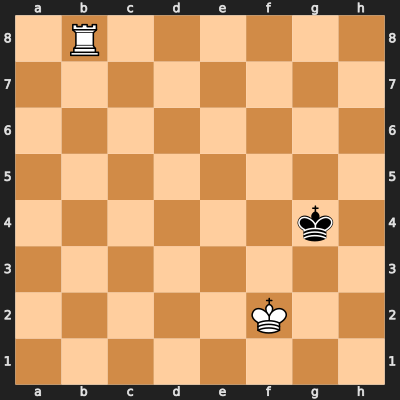

I0000 00:00:1729885022.501253  667487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-25 21:37:02.659884: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading model from dqn_model_checkpoint.weights.h5


/home/jamal/si5/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


start
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py
end
Replaying...
start
ERROR: Could not find file /tmp/ipykernel_667487/976329073.py


KeyboardInterrupt: 

In [5]:
import os
%load_ext memory_profiler


def train_agent():
    env = RookKingEnv(2,demo_mode=True)
    state_size = 8 * 8 * 3  # 8x8 board with 3 channels
    agent = MCTSAgent(state_size)
    batch_size = 8
    episodes = 50000
    target_update_frequency = 10
    checkpoint_frequency = 2

    model_file = "dqn_model_checkpoint.weights.h5"
    move_mapping_file = "move_mapping.json"

    if os.path.exists(model_file):
        print(f"Loading model from {model_file}")
        agent.load(model_file)
        agent.load_move_mapping(move_mapping_file)
    else:
        agent.load_move_mapping(move_mapping_file)
        print("No model found, training a new one.")


    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        moves_made = 0


        # Update stage based on progress
        if e == episodes == 300:
            env = RookKingEnv(2)
            agent.epsilon = 1
            print("Moving to stage 2")
        elif e == episodes // 2:
            env = RookKingEnv(3)
            agent.epsilon = 1
            print("Moving to stage 3",agent.epsilon_decay)
        elif e == 3 * episodes // 4:
            agent.epsilon = 1
            env = RookKingEnv(4)
            print("Moving to stage 4")

        while True:
            legal_moves = env.get_legal_actions()
            # env.render_board()
            fen = env.get_fen()
            action = agent.act(fen, legal_moves)
            next_state, reward, done = env.step(action)
            fen = env.get_fen()

            agent.remember(state, action, reward, next_state,fen, done)
            total_reward += reward
            moves_made += 1

            state = next_state
            legal_moves = env.get_legal_actions()

            # env.render_board()

            if done or moves_made > 2:  # Prevent infinite games
                print(f"Episode: {e}/{episodes}, Score: {total_reward}, epsilon: {agent.epsilon}")
                break

            if e % checkpoint_frequency == 0:
                agent.replay(batch_size)
        # env.render_board()

        # Update target network periodically
        if e % target_update_frequency == 0:
            agent.update_target_model()

        # Save checkpoints
        if e % checkpoint_frequency == 0:
            agent.save(model_file)
            print("saved")
            agent.save_move_mapping()

    return agent

if __name__ == "__main__":
    agent = train_agent()

In [8]:
import chess
import random
import json
import numpy as np
import time
from IPython.display import display, clear_output, SVG

state_size = 8 * 8 * 3  # 8x8 board with 3 channels
agent = MCTSAgent(state_size)
batch_size = 128
episodes = 50000
target_update_frequency = 10
checkpoint_frequency = 10
model_file = "dqn_model_checkpoint.weights.h5"
move_mapping_file = "move_mapping.json"
print(f"Loading model from {model_file}")
agent.load(model_file)
agent.load_move_mapping(move_mapping_file)
env = RookKingEnv(stage=2,demo_mode=True)
with open(move_mapping_file, "r") as file:
    move_mapping = json.load(file)
def random_move(board):
    """Select a random legal move from the board."""
    legal_moves = list(board.legal_moves)
    return random.choice(legal_moves) if legal_moves else None

def play_game(agent):
    """Play a game with the model vs a random opponent."""
    done = False
    step = 0
    while not done:
        time.sleep(1)  # Pause for visibility
        legal_moves = env.get_legal_actions()

        # Use the agent's act method to determine the action
        action = agent.act(env.get_fen(), legal_moves)  # Assuming act takes state and legal moves
        print(f"Agent's move: {action}")

        next_state, reward, done = env.step(action)
        env.render_board()  # Show the board after the agent's move

        # if not done:
        #     time.sleep(1)  # Pause before the opponent's move
        #     opponent_action = random_move(env.board)
        #     if opponent_action:
        #         print(f"Opponent's move: {opponent_action}")
        #         env.step(opponent_action)
        #         env.render_board()  # Show the board after the opponent's move

        state = next_state  # Update the state
        step += 1

    if env.board.is_checkmate():
        print("Checkmate! The model wins!")
    elif env.board.is_stalemate():
        print("Stalemate! It's a draw.")
    else:
        print("Game over!")

play_game(agent)  # Use the agent to play

play_game(agent.model)  # Use the trained model to play


TypeError: MCTSAgent.__init__() got an unexpected keyword argument 'demo_mode'